# 1. DG_AI_System

## 구조

* DG_AI_System: root
    * DG_DLNets

    * DG_IpUS

    * DG_ISpU


---

# 2. DG_IpUS

## 2.1. 영상 폴더 영상 불러오기 기능
* 영상 폴더와 폴더 내 영상 불러오기 기능
* 다음/연속 기능 포함 (--> iterable을 반환함으로서 추후 응용프로그램에서 처리)

### 2.1.1. 파일(영상) 입출력 클래스

In [5]:
import os

import numpy as np
import cv2

class DG_FileSystem:
    # 유니코드로 이루어진 파일경로를 읽기위한 함수.
    # 동작은 cv2.imread()와 동일하다.
    # scrapped from: https://cjh5414.github.io/python-with/
    def imread(filename, flags=cv2.IMREAD_COLOR, dtype=np.uint8):
        try:
            n = np.fromfile(filename, dtype)
            img = cv2.imdecode(n, flags)
            return img
        except Exception as e:
            print(e)
            return None

    # 유니코드로 이루어진 파일경로를 읽기위한 함수.
    # 동작은 cv2.imwrite()와 동일하다.
    # scrapped from: https://cjh5414.github.io/python-with/
    def imwrite(filename, img, params=None):
        try:
            ext = os.path.splitext(filename)[1]
            result, n = cv2.imencode(ext, img, params)
            if result:
                with open(filename, mode='w+b') as f:
                    n.tofile(f)
                    return True
            else:
                return False
        except Exception as e:
            print(e)
            return False

    # ------------------------------------------------

    def openImage(path:str):
        if not os.path.isfile(path):
            raise Exception(f"Could not open '{path}'. The file does not exist.")
            
        frame_bgr = DG_FileSystem.imread(path)

        if (type(frame_bgr) == type(None)):
            raise Exception(f"Could not open '{path}' using cv2.")

        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        return frame_rgb
            

    def openImages(path_list:list):
        return [FileOpener.openImage(path) for path in path_list]
    
    def openImagesFromDir(dir_path:str):
        if not os.path.isdir(dir_path):
            raise Exception(f"Could not open '{dir_path}': is not a directory.")
        
        file_path_list = []
        frame_rgb_list = []
        for file_basename in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_basename)
            file_name, file_extension = os.path.splitext(file_path)
            if file_extension.lower() in ['.jpg', '.jpeg', '.png']:
                file_path_list.append(file_path)
                frame_rgb_list.append(DG_FileSystem.openImage(file_path))
        return file_path_list, frame_rgb_list

### 2.1.2. 파일(영상) 입출력 클래스 사용 예시

`DG_FileSystem` 클래스는 아래와 같은 방식으로 사용할 것입니다.

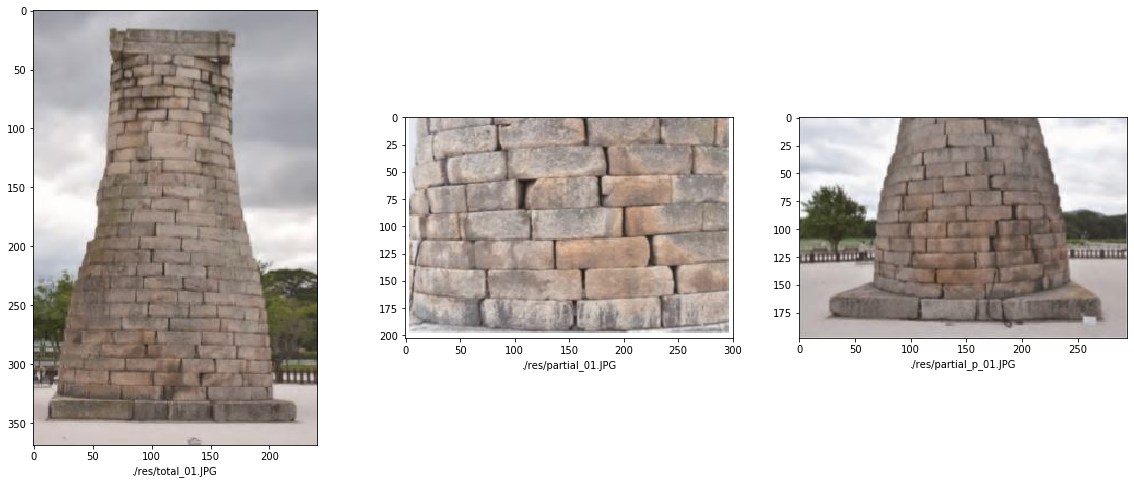

In [6]:
import matplotlib.pyplot as plt

# DG_FileSystem 사용
file_path_list, frame_rgb_list = DG_FileSystem.openImagesFromDir('./res')

# Plotting
n_of_items = len(file_path_list)
fig, axes = plt.subplots(1, n_of_items, figsize=(20,8))
for file_basename, frame_rgb, ax in zip(file_path_list, frame_rgb_list, axes):
    ax.imshow(frame_rgb)
    ax.set_xlabel(file_basename)
plt.show()

## 2.2. 불러온 영상 분류 저장 기능
* (선호/비선호, 정상/비정상, 다양한 클래스로...)
* 버튼 선택을 통해 분류
* 클래스별 폴더에 분류 저장

### 2.2.1. 클래스를 다루는 클래스

In [26]:
import numpy as np

class DG_ClassWrapper:
    class_list = []

    # 새로운 ML클래스 생성
    def new(class_name:str, label:int,
            is_fixed_size:bool=False, data_size:tuple=()):

        if DG_ClassWrapper.does_class_exist(class_name, label):
            return None

        new_class = DG_ClassWrapper.DG_Class(class_name, label, data_size, is_fixed_size)

        DG_ClassWrapper.class_list.append(new_class)
        return new_class

    # 중복된 ML클래스가 존재하는지 확인
    def does_class_exist(class_name:str, label:int):
        for c in DG_ClassWrapper.class_list:
            try:
                if c.name == class_name:
                    raise Exception(f"Class with the name '{class_name}' already exists.")
                if c.label == label:
                    raise Exception(f"Class with the label '{label}' already exists.")
            except Exception as err:
                return True
        return False
    
    # ML클래스 인스턴스를 생성하기 위한 클래스
    class DG_Class:
        def __init__(self, class_name:str, label:int,
                    is_fixed_size:bool=False, data_size:tuple=()):
            self.name = class_name

            self.label = label

            self.data_size = data_size
            self.is_fixed_size = is_fixed_size
            self.samples = []
        
        # 단일 샘플을 클래스 인스턴스에 등록
        def addSample(self, data):
            if self.is_fixed_size:
                if data.shape != self.data_size:
                    raise Exception(f"data.shape does not match with {self.data_size}")
            self.samples.append(data)
        
        # 다중 샘플을 클래스 인스턴스에 등록
        def addSamples(self, data_list):
            for data in data_list:
                self.addSample(data)

        # 등록된 샘플들과 레이블을 1:1 대응시켜 반환: returns (x, y)
        def createDataset(self):
            return self.samples, [self.label]*len(self.samples)


### 2.2.2. 클래스 생성 및 샘플 추가 예시
* DG_ClassWrapper.new()
    * .addSample()

In [32]:
file_path_list, frame_bgr_list = DG_FileSystem.openImagesFromDir('./res')
frame_bgr_01 = cv2.imread('res/partial_01.JPG')

x_train, y_train = [], []

class_01 = DG_ClassWrapper.new('Class01', 1)
class_02 = DG_ClassWrapper.new('Class02', -1)

if class_01:
    class_01.addSample(frame_bgr_01)
    class_01.addSamples(frame_bgr_list)

    x_train_01, y_train_01 = class_01.createDataset()

    x_train += x_train_01
    y_train += y_train_01

if class_02:
    class_02.addSamples(frame_bgr_list)

    x_train_02, y_train_02 = class_02.createDataset()

    x_train += x_train_02
    y_train += y_train_02

x_train_text = str(x_train).split('\n')[0]
print(x_train_text)
print(y_train)

print([c.name for c in DG_ClassWrapper.class_list],
      f'total {len(DG_ClassWrapper.class_list)} classes.')

[]
[]
['Class01', 'Class02'] total 2 classes.
